# 1. Introduction
This notebook contains code that will extract features from processed lung nodule CT images originally from the SPIE-AAPM Lung CT Challenge which will be inputted into a support vector machine (SVM) algorithm to determine whether the lung nodule is cancerous or benign.

## Load libraries

In [1]:
# Math & data
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Image processing
import cv2
import skimage.feature as sk
import mahotas.features as feature

# Statistics
from scipy import interp

# Machine learning
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Misc
import os
import collections
from itertools import cycle

## Define functions

In [2]:
def glcm_feat_extraction(image):
    # Use GLCM to find features
    #glcm = sk.greycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
    glcm = sk.greycomatrix(image, [1], [0, 3*np.pi/4])
    
    # mean of GLCM directions for rotational invariance
    glcm_mean = np.mean(glcm, axis=3, keepdims=True)
    
    # Find features from GLCM
    contrast = sk.greycoprops(glcm_mean, 'contrast')
    dissimilarity = sk.greycoprops(glcm_mean, 'dissimilarity')
    homogeneity = sk.greycoprops(glcm_mean, 'homogeneity')
    ASM = sk.greycoprops(glcm_mean, 'ASM')
    energy = sk.greycoprops(glcm_mean, 'energy')
    correlation = sk.greycoprops(glcm_mean, 'correlation')
    
    return contrast, homogeneity, ASM, energy   # test

def LBP_feat_extraction(image):
    # LBP features
    # see: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
    feat_lbp = sk.local_binary_pattern(image, 29, 7, 'uniform')

    lbp_hist,_ = np.histogram(feat_lbp, 7)
    lbp_hist = np.array(lbp_hist, dtype=float)
    lbp_prob = np.divide(lbp_hist, np.sum(lbp_hist))
    lbp_energy = np.sum(lbp_prob**2)
    
    return [lbp_energy]

def pixel_count(image):
    ct = 0
    for row in nodule_nums:
        for value in row:
            if value > 0:
                ct += 1
    return [ct]

# by: Josh Lee
# https://stackoverflow.com/questions/2158395/flatten-an-irregular-list-of-lists
def flatten(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

# 2. Load Lung Nodule Data
Change data_dir to the main folder with all of the files

In [3]:
data_dir = 'C:/Users/moogl/Desktop/UChicago/Capstone Project/2. Implementation/Lung CT Data/SPIE-AAPM Lung CT Challenge/'

# csv to pandas dataframe
coordinates_df = pd.read_csv(data_dir + 'ipynb files/' + 'Calib and test set labels (with 2 nodule patients).csv')
coordinates_df.sort_values(by=['Patient ID'], inplace=True)
coordinates_df.set_index('Patient ID', drop=True, inplace=True)
coordinates_df.reset_index(inplace=True)

patients = list(coordinates_df['Patient ID'])

coordinates_df.head()

,Patient ID,Diagnosis,x,y,Instance Number
0,CT-Training-BE001,benign,405,296,169
1,CT-Training-BE002,benign,184,268,117
2,CT-Training-BE006,benign,449,266,241
3,CT-Training-BE007,benign,385,206,194
4,CT-Training-BE010,benign,120,336,69


# 3. Extract features from nodules
Features extracted and placed into a dataframe:
> - Lung nodule size (# of pixels)
> - Energy (LBP & GLCM)
> - Contrast
> - Homogeneity
> - Angular second moment (ASM)

Ensure that the path leads to the folder: '6. Clean Crop/'. 

In [4]:
feat_array = []

for index, nodule in enumerate(patients):    
    if nodule == patients[index-1]:
        path = data_dir + '6. Clean Crop/' + nodule + '_2_cropped.tiff'
    else:
        path = data_dir + '6. Clean Crop/' + nodule + '_cropped.tiff'

    # read nodule image as array of numbers
    nodule_nums = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Feature extraction
    pixel_count_feat = pixel_count(nodule_nums)
    
    glcm_feat = glcm_feat_extraction(nodule_nums)
    glcm_feat = flatten(glcm_feat)
    
    LBP_feat = LBP_feat_extraction(nodule_nums)
    F13 = feature.haralick(nodule_nums).mean(0).tolist()
    
    # store features in temp numpy array
    feat_array.append((pixel_count_feat + glcm_feat + LBP_feat))
    
    #feat_array.append((glcm_feat + LBP_feat + F13))
    #feat_array.append((pixel_count_feat + glcm_feat + LBP_feat + F13))

## Save feature array in dataframe

In [5]:
# Convert numpy array to pandas dataframe
feat_array_full = np.array(feat_array)
feat_df = pd.DataFrame(feat_array)

feat_df.columns = ['Number of Pixels' ,'GLCM Contrast', ' GLCMHomogeneity', ' GLCM ASM', 'GLCM Energy', 'LBP Energy']

feat_df.info
# write dataframe to .csv file
#feat_df.to_csv(data_dir + 'Features Dataframe.csv')
feat_df.round(1).head()

,Number of Pixels,GLCM Contrast,GLCMHomogeneity,GLCM ASM,GLCM Energy,LBP Energy
0,13,37.8,1.0,1.0,1.0,1.0
1,21,56.2,1.0,1.0,1.0,1.0
2,295,181.4,0.9,0.8,0.9,0.9
3,482,470.2,0.9,0.8,0.9,0.9
4,634,215.1,0.8,0.7,0.8,0.9


# 4. Data Preprocessing

## Standardize features
Centers the values so that the mean for each feature is zero and scales to features to unit variance. This is done to remove bias in the data that would otherwise have different scales.

[Scaling docs](http://benalexkeen.com/feature-scaling-with-scikit-learn/)

In [6]:
# "Standardize features by removing the mean and scaling to unit variance"
scaler = preprocessing.StandardScaler()
feat_scaled = scaler.fit_transform(feat_array_full)

feat_scaled_df = pd.DataFrame(feat_scaled)

feat_scaled_df.columns = ['Number of Pixels', 'GLCM Contrast', ' GLCMHomogeneity', ' GLCM ASM', 'GLCM Energy', 'LBP Energy']

feat_scaled_df.round(2).head()

,Number of Pixels,GLCM Contrast,GLCMHomogeneity,GLCM ASM,GLCM Energy,LBP Energy
0,-1.17,-1.00,1.20,1.33,1.20,1.62
1,-1.14,-0.94,1.17,1.30,1.18,1.54
2,-0.37,-0.53,0.24,0.26,0.29,0.69
3,0.16,0.43,-0.12,-0.19,-0.12,0.20
4,0.58,-0.42,-0.53,-0.67,-0.58,-0.54


# 5. Principle Component Analysis (PCA)
A way to deal with overfitting is to use PCA to reduce the number of features and keep the most relevant. Using PCA, the number of features will be reduced from 6 to 4.

In [7]:
# Instantiate PCA
pca = PCA(n_components=4, whiten=True) # was 4 with all features

# Run PCA on the data
feat_reduc = pca.fit(feat_scaled_df).transform(feat_scaled_df)

print(f'PCA explained variance: {pca.explained_variance_}')

PCA explained variance: [5.5469172  0.43565127 0.08089857 0.00795642]


## Store values in dataframe

In [8]:
feat_reduc_df = pd.DataFrame(feat_reduc)
feat_reduc_df.head()

,0,1,2,3
0,-1.306392,-0.077998,1.397973,1.067861
1,-1.265583,-0.119974,1.226719,1.059346
2,-0.404961,0.290080,1.318471,-0.849168
3,0.132183,-0.547454,0.997631,-0.567614
4,0.461200,1.245188,0.238197,-1.528097


# 6. Append Truth Values to Dataframe
Adds a truth column containing the variable to predict:
> - 0: benign nodule
> - 1: malignant nodule

In [9]:
## adding truth column to x_df
coordinates_df.replace({'Diagnosis' : {'benign':0, 'Benign nodule':0, 'malignant':1, 'Primary lung cancer':1,
                                                        'Primary lung cancer ':1, 'Suspicious malignant nodule':1}}, inplace=True)

# Combining non-rotation truth values into truth_column
truth_column_no_rota = coordinates_df['Diagnosis']
feat_reduc_df['Truth'] = truth_column_no_rota

feat_reduc_df.head()

,0,1,2,3,Truth
0,-1.306392,-0.077998,1.397973,1.067861,0
1,-1.265583,-0.119974,1.226719,1.059346,0
2,-0.404961,0.290080,1.318471,-0.849168,0
3,0.132183,-0.547454,0.997631,-0.567614,0
4,0.461200,1.245188,0.238197,-1.528097,0


# 7. Support Vector Machine (SVM) Algorithm

## Use GridSearchCV
Finds the best hyperparameters to use for the SVM algorithm.

In [10]:
# split dataframe into feature (X) and truth label (y) datasets
X = feat_reduc_df[feat_reduc_df.columns[:-1]]
y = feat_reduc_df['Truth']

In [11]:
# thanks to: https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1, 'auto', 'scale']
    param_grid = {'C': Cs, 'gamma' : gammas, 'probability': [True, False]}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

# Run GridSearchCV with 8 folds cross validation using SVM as the estimator
svc_param_selection(X, y, 8)

C:\Users\moogl\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1, 'gamma': 1, 'probability': True}

## Initialize SVM with the best hyperparameters

In [12]:
# initialize SVM
clf = svm.SVC(C=1 ,kernel='rbf', gamma='scale', probability=True)
print("\n", clf)


 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


# 8. Model Evaluation

## Stratified K-Fold and ROC
Use 8 folds and to be used in the ROC curve

In [13]:
# implement stratified k-fold
skf = StratifiedKFold(n_splits=8)

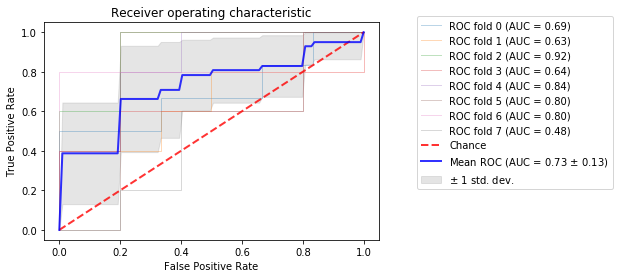

In [14]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in skf.split(X, y):
    probas_ = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

## To get a better measure of the AUC, run the above multiple times

In [15]:
auc_list = []

for epoch in range(0, 1000):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in skf.split(X, y):
        probas_ = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    auc_list.append(mean_auc)

average_auc = np.mean(auc_list)
print(f'Average AUC over 1000 epochs: {average_auc}')

Average AUC over 1000 epochs: 0.7235709493929189
